In [1]:
%load_ext autoreload
%autoreload 2

import os
from glob import glob
from os.path import join

import calendar

import tqdm
import cftime
import dask

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import cm

from distributed import wait

import warnings
warnings.simplefilter("ignore", category=FutureWarning)

%matplotlib inline

In [2]:
import dask
from dask_jobqueue import PBSCluster 

# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-worker',
    cores = 1,
    memory = '4GiB',
    processes = 1,
    local_directory = '/local_scratch/pbs.$PBS_JOBID/dask/spill',
    log_directory ='/glade/derecho/scratch/wwieder/temp/dask-scratch-space',
    resource_spec = 'select=1:ncpus=1:mem=4GB',
    queue = 'casper',
    walltime = '15:00',
    interface = 'ext',
    job_extra_directives=['-m n']
)

In [3]:
# Next, print the job script for our debugging: 
print(cluster.job_script()) 


#!/usr/bin/env bash

#PBS -N dask-worker
#PBS -q casper
#PBS -A P93300041
#PBS -l select=1:ncpus=1:mem=4GB
#PBS -l walltime=15:00
#PBS -e /glade/derecho/scratch/wwieder/temp/dask-scratch-space/
#PBS -o /glade/derecho/scratch/wwieder/temp/dask-scratch-space/
#PBS -m n

/glade/u/apps/opt/conda/envs/npl-2023b/bin/python -m distributed.cli.dask_worker tcp://128.117.208.96:39651 --nthreads 1 --memory-limit 4.00GiB --name dummy-name --nanny --death-timeout 60 --local-directory /local_scratch/pbs.$PBS_JOBID/dask/spill --interface ext



In [4]:
# Add a client and scale up:
from dask.distributed import Client
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/NewLogin/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/NewLogin/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.96:39651,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/NewLogin/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
# Scale the cluster to n workers
cluster.scale(20)

In [15]:
#coords for P. Pine snowtel EMBER site = 46.846°N−116.716°W
site = 'ember_1'
plat, plon = 46.846, (360-116.716) 
def preprocess (ds,plat=plat,plon=plon):

    LATI=ds.LATIXY.isel(time=0,lon=0).values
    LONG=ds.LONGXY.isel(time=0,lat=0).values
    ds = ds.assign_coords({"lon": LONG, 'lat':LATI})
    ds_new = ds.sel(lat=plat,lon=plon, method='nearest')

    return ds_new

# modifying TBOT and Precip for Moscow Mt

In [16]:
fin = '/glade/campaign/cgd/tss/people/swensosc/NLDAS'
ftypes = ['Precip','Solar','TPQWL']
dir_in = 'clmforc.NLDAS2.c2020.0125x0125.'
years = ['200','201','202'] 

out_dir = '/glade/campaign/cgd/tss/people/wwieder/'+site+'/datm_nldas3/'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir, exist_ok=True)            

for ftype in ftypes: 
    print('starting '+ftype)
    for year in years:
        # list of files
        files = []
        files.extend(sorted(glob(join(fin,'*'+ftype+"."+year+"*.nc"))))
        
        # Open datasets
        ds = xr.open_mfdataset(files, decode_times=True, combine='by_coords',parallel=True)

        # Assign coords
        LATI=ds.LATIXY.isel(time=0,lon=0).values
        LONG=ds.LONGXY.isel(time=0,lat=0).values
        ds = ds.assign_coords({'lon': LONG, 'lat':LATI})

        # Subset data & modify fillValues
        ds = ds.sel(lat=plat,lon=plon, method='nearest')
        ds= ds.expand_dims(dim={"lat": 1},axis=1)
        ds= ds.expand_dims(dim={"lon": 1},axis=2)
        ds['LONGXY'] = ds['LONGXY'].isel(time=0)
        ds['LATIXY'] = ds['LATIXY'].isel(time=0)
        ds['time'].attrs['_FillValue'] = 1.e36
        ds['LONGXY'].attrs['_FillValue'] = 1.e36
        ds['LATIXY'].attrs['_FillValue'] = 1.e36
        ds['lat'].attrs['_FillValue'] = 1.e36
        ds['lon'].attrs['_FillValue'] = 1.e36
        print('...loading data...')
        ds = ds.persist() 
        _ = wait(ds)
        
        if ftype == 'TPQWL':
            ds['TBOT'] = ds.TBOT - 3.
            print('-- modified TBOT --')
        if ftype == 'Precip':
            ds['PRECTmms'] = ds['PRECTmms'] * 1.4 
            print('-- modified precip --')
            
        if year == '202':
            fout = out_dir+'clmforc.NLDAS2.c2020.'+ftype+'.'+site+'.'+year+'0-2022_nc4.nc'
        else: 
            fout = out_dir+'clmforc.NLDAS2.c2020.'+ftype+'.'+site+'.'+year+'0-'+str(int(year)*10+9)+'_nc4.nc'
        ds.to_netcdf(fout)
        print('wrote '+fout)

print("-- done! --")

starting Precip
...loading data...
-- modified precip --
wrote /glade/campaign/cgd/tss/people/wwieder/ember_1/datm_nldas3/clmforc.NLDAS2.c2020.Precip.ember_1.2000-2009_nc4.nc
...loading data...
-- modified precip --
wrote /glade/campaign/cgd/tss/people/wwieder/ember_1/datm_nldas3/clmforc.NLDAS2.c2020.Precip.ember_1.2010-2019_nc4.nc
...loading data...
-- modified precip --
wrote /glade/campaign/cgd/tss/people/wwieder/ember_1/datm_nldas3/clmforc.NLDAS2.c2020.Precip.ember_1.2020-2022_nc4.nc
starting Solar
...loading data...
wrote /glade/campaign/cgd/tss/people/wwieder/ember_1/datm_nldas3/clmforc.NLDAS2.c2020.Solar.ember_1.2000-2009_nc4.nc
...loading data...
wrote /glade/campaign/cgd/tss/people/wwieder/ember_1/datm_nldas3/clmforc.NLDAS2.c2020.Solar.ember_1.2010-2019_nc4.nc
...loading data...
wrote /glade/campaign/cgd/tss/people/wwieder/ember_1/datm_nldas3/clmforc.NLDAS2.c2020.Solar.ember_1.2020-2022_nc4.nc
starting TPQWL
...loading data...
-- modified TBOT --
wrote /glade/campaign/cgd/tss/

In [ ]:
ds

In [13]:
ds = xr.open_dataset('/glade/campaign/cgd/tss/people/wwieder/'+site+
                     'datm_nldas2/clmforc.NLDAS2.c2020.Solar.'+site+'.2010-2019_nc4.nc',
                     decode_times=True)

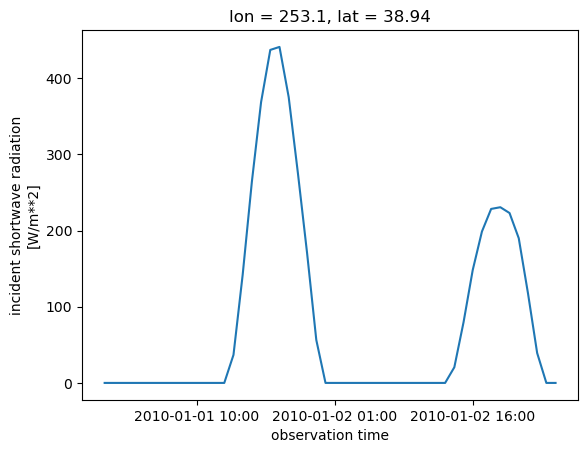

In [14]:
ds.FSDS.isel(time=slice(0,50)).plot() ;

In [15]:
# May have to manually write these to nc5

In [16]:
ds = xr.open_dataset('/glade/campaign/cgd/tss/people/wwieder/gothic/clmforc.NLDAS2.c2020.Precip.gothic.2010-2019_nc4.nc',
                     decode_times=True)


In [19]:
cumPPT

<xarray.DataArray 'PRECTmms' (time: 87600, lat: 1, lon: 1)>
array([[[  0.     ]],

       [[  0.     ]],

       [[  0.     ]],

       ...,

       [[647.44556]],

       [[647.44556]],

       [[647.4755 ]]], dtype=float32)
Coordinates:
  * time     (time) object 2010-01-01 00:30:00.000054 ... 2019-12-31 23:30:07...
  * lon      (lon) float32 253.1
  * lat      (lat) float32 38.94

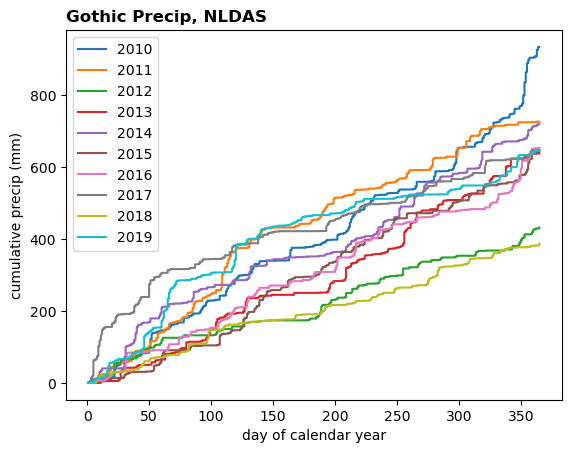

In [22]:
sph = 3600
cumPPT = ((ds.PRECTmms.groupby('time.year').cumsum())*sph)
cumPPT = cumPPT.isel(lat=0, lon=0)
for year in range(2010, 2020):
    plot = xr.where(cumPPT['time.year'] == year, cumPPT, np.nan)
    x = plot['time.dayofyear']
    y = plot
    plt.plot(x, y, label=str(year))

plt.legend()
plt.ylabel('cumulative precip (mm)')
plt.xlabel('day of calendar year')
plt.title('Gothic Precip, NLDAS', loc='left', fontsize='large', fontweight='bold') ;